In [1]:
#cd C:\Users\marcb\OneDrive\Desktop\Kaggle_Competitions\Kaggle-Competitions\HMS-harmful-brain-activity

import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

# PyTorch for deep learning
import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# torchvision for image processing and augmentation
import torchvision.transforms as transforms

# Suppressing minor warnings to keep the output clean
warnings.filterwarnings('ignore', category=Warning)

# Reclaim memory no longer in use.
gc.collect()


# Configuration class containing hyperparameters and settings
class Config:
    seed = 42 
    image_transform = transforms.Resize((440,440))  
    batch_size = 50
    num_epochs = 10
    num_folds = 5

# Set the seed for reproducibility across multiple libraries
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

# Define the 'Kullback Leibler Divergence' loss function
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

# Reclaim memory no longer in use.
gc.collect()

# Load training data

PATH_OR = "C:\\Users\\marcb\\OneDrive\\Desktop\\Kaggle_Competitions\\Kaggle-Competitions\\HMS-harmful-brain-activity\\"
test_eeg = PATH_OR+'hms-harmful-brain-activity-classification/train_eegs/'
test_specs = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
test_csv = PATH_OR+'hms-harmful-brain-activity-classification/train.csv'

df = pd.read_csv(test_csv)
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

READ_SPEC_FILES = True

# READ ALL SPECTROGRAMS
PATH = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

    
import pywt, librosa
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')

    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        
    return img
    
    
from joblib import Parallel, delayed
import pandas as pd
import os

def process_spectrogram(f, PATH2):
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    return name, tmp.iloc[:,1:].values

def process_eeg(eeg_id, PATH2):
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet')
    return eeg_id, img

PATH2 = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')

results = Parallel(n_jobs=16)(delayed(process_spectrogram)(f, PATH2) for f in files2)
spectrograms2 = dict(results)

from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)

PATH2 = PATH_OR+'hms-harmful-brain-activity-classification/train_eegs/'
DISPLAY = 0
EEG_IDS2 = train.eeg_id.unique()

print('Converting Test EEG to Spectrograms...'); print()
results = Parallel(n_jobs=16)(delayed(process_eeg)(eeg_id, PATH2) for  eeg_id in (EEG_IDS2))
all_eegs2 = dict(results)

import cv2
eegs = np.zeros([17089,128,256,4])
specs = np.zeros([17089,400,400])
for i in range(17089):
    eegs[i] = all_eegs2[train.eeg_id[i]]
del all_eegs2
for i in range(17089):
    specs[i] = cv2.resize(spectrograms2[train.spec_id[i]],(400,400))
del spectrograms2
    
from sklearn.model_selection import train_test_split
eps=1e-8

from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, train_feats, eegs, specs):
        self.train_feats = train_feats
        self.eegs = eegs
        self.specs = specs
    def __len__(self):
        return len(self.train_feats)
    def __getitem__(self, index):              
        x_eeg = self.eegs[index]
        #x_eeg = torch.tensor((x_eeg-x_eeg.min())/(x_eeg.max()-x_eeg.min()+eps))
        x_spec = self.specs[index]
        x_eeg = torch.tensor(x_eeg)
        torch.nan_to_num(x_eeg)
        #x_spec = torch.tensor((x_spec-x_spec.min())/(x_spec.max()-x_spec.min()+eps))
        x_spec = torch.tensor(x_spec).unsqueeze(0)
        torch.nan_to_num(x_spec)
        y = self.train_feats[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].iloc[index].values      
        return x_eeg, x_spec, y
        
        
total_idx = np.arange(len(train))
train_idx, val_idx = train_test_split(total_idx, test_size=0.2)
train_idx

def redo_classifier(model):
    num_in_features = model.get_classifier().in_features
    hidden_size = 64
    n_classes=32
    dropout_rate=.2
    d2 = .1
    for name, param in model.named_parameters():
        ijk=0
        #print (name)
        
    # Replace the existing classifier. It's named: classifier
    if "head.fc" in name:
        model.head.fc = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        nn.SiLU(),
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        nn.Linear(hidden_size, 32, bias=True),
        #nn.Softmax(dim=0),
        # nn.BatchNorm1d(32),
        nn.Linear(32, out_features=n_classes, bias=True),
        #nn.Softmax(dim=0)
        )
    elif "fc" in name:
        model.fc = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        nn.Hardswish(),
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        #nn.Linear(hidden_size, 32, bias=True),
        #nn.SiLU(),
        # nn.BatchNorm1d(32),
        nn.Linear(hidden_size, out_features=n_classes, bias=True),
        )
    elif "classifier" in name:
        model.classifier = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        nn.SiLU(),
        #nn.Linear(hidden_size, 32, bias=True),
        #nn.Hardswish(),
        # nn.BatchNorm1d(32),
        nn.Linear(hidden_size, out_features=n_classes, bias=True),
        )
    elif "head" in name:
        model.head = nn.Sequential(
        #nn.Dropout(dropout_rate, inplace=True),
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        nn.Hardswish(),
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        #nn.Linear(hidden_size, 32, bias=True),
        #nn.Hardswish(),
        # nn.BatchNorm1d(32),
        nn.Linear(hidden_size, out_features=n_classes, bias=True),
        )
    #elif "neck" in name:
    #    model.head = nn.Sequential(
    #    nn.AdaptiveAvgPool2d((64,1)),
    #    nn.Dropout(dropout_rate),
    #    nn.Linear(in_features=1, out_features=64, bias=False),
        #nn.LeakyReLU(.1,inplace=True),
        #nn.Dropout(dropout_rate),
        #nn.Linear(in_features=hidden_size, out_features=1, bias=False),
        #nn.Sigmoid())
    print (name)
    #print (model)
    return model

# model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=6, in_chans=1)
# model = redo_classifier(model)
#model

import torch
import torch.nn as nn

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.model1 = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=4, drop_path_rate=.3,num_classes=32,pretrained=True)

        self.model2 = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=1, drop_path_rate=.2,num_classes=32,pretrained=True)
    
        self.fc = nn.Linear(32, 6)

    def forward(self, x1, x2):

        # Run the first tensor through the first model
        output1 = self.model1(x1.float())

        # Run the second tensor through the second model
        output2 = self.model2(x2.float())

        # Concatenate the outputs
        combined_output = output1*output2

        # Pass the combined output through the final linear layer
        combined_output = self.fc(combined_output)

        return combined_output

# Determine device availability
import tqdm
from sklearn.model_selection import train_test_split

import albumentations as A
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming train_feats is defined and contains the training features and labels
# total_idx = np.arange(len(train_feats))
total_idx = np.arange(len(train))
# np.random.shuffle(total_idx)

gc.collect()
# Cross-validation loop
from sklearn.model_selection import KFold, GroupKFold
#import tensorflow.keras.losses as tf_loss
all_oof = []
all_true = []
criterion = nn.KLDivLoss(reduction='batchmean')
#criterion = tf_loss.KLDivergence()
num_folds=3
for fold in range(num_folds):
    # Split data into train and test sets for this fold
    #train_idx, test_idx = train_test_split(total_idx, test_size=0.1)
    test_idx = total_idx[fold * len(total_idx) // (num_folds):(fold + 1) * len(total_idx) // (Config.num_folds)]
    train_idx = np.array([idx for idx in total_idx if idx not in test_idx])
    print('train length: ', len(train_idx), ' test length: ', len(test_idx))
    train_eegs = [eegs[i] for i in train_idx]
    test_eegs = [eegs[i] for i in test_idx]
    train_specs = [specs[i] for i in train_idx]
    test_specs = [specs[i] for i in test_idx]
    # keys = list(data.item().keys())
    # test_keys = [keys[i] for i in test_idx]
    # train_keys = [keys[i] for i in train_idx]
    train_dataset = CustomDataset(train.iloc[train_idx], train_eegs,train_specs)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,  num_workers=0, drop_last=True)
    test_dataset = CustomDataset(train.iloc[test_idx], test_eegs,test_specs)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False,  num_workers=0, drop_last=True)
    torch.cuda.empty_cache()

    # Initialize EfficientNet-B0 model with pretrained weights
    #model = timm.create_model('convnext_base', pretrained=True,drop_rate=.2,drop_path_rate=.2 ,num_classes=1000, in_chans=1)
    #model1 = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=4, drop_path_rate=.3,num_classes=1000,pretrained=True)
    #model = model.eval()

    # get model specific transforms (normalization, resize)
    # data_config = timm.data.resolve_model_data_config(model)
    # transforms = timm.data.create_transform(**data_config, is_training=False)
    #model1 = redo_classifier(model1)
    # model2 = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=1, drop_path_rate=.2,num_classes=1000,pretrained=True)
    # model2 = redo_classifier(model2)
    model=CombinedModel()
    #model = nn.Sequential(nn.Conv2d(5,3,(1,1)),m1)
    model.to(device)
    

    optimizer = optim.NAdam(model.parameters(), lr=0.0002, weight_decay=0.02)
    scheduler = CosineAnnealingLR(optimizer, T_max=11)

    best_test_loss = float('inf')
    train_losses = []
    test_losses = []

    print(f"Starting training for fold {fold + 1}")

    # Training loop
    for epoch in range(3):
        model.train()
        train_loss = []

        count=0
        for x,x2,y in train_dataloader:
            count=count+1
            optimizer.zero_grad()

            x = x.permute(0,3,1,2)

            train_pred = model(x.to(device),x2.to(device))
            #loss = KL_loss(y.to(device),train_pred)
            loss = criterion(F.log_softmax(train_pred, 1), y.to(device))
            # loss = criterion(y,train_pred.detach().cpu().numpy())
            # loss = torch.tensor(loss.numpy(), requires_grad=True)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss.append(loss.item())
            if count%30==0:
                print(loss.item())

        epoch_train_loss = np.mean(train_loss)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

        scheduler.step()

        # Evaluation loop
        model.eval()
        test_loss = []
        with torch.no_grad():
            for x,x2, y in test_dataloader:
                x = x.permute(0,3,1,2)
                #x = x.unsqueeze(1)
                #x = transforms(x)

                test_pred = model(x.to(device), x2.to(device))
                loss = criterion(F.log_softmax(test_pred, 1), y.to(device))
                #loss = criterion(F.log_softmax(train_pred, -1), y.to(device))
                # loss = criterion(test_pred.detach().cpu.numpy(),y)
                # loss = torch.tensor(loss.numpy())
                test_loss.append(loss.item())

        epoch_test_loss = np.mean(test_loss)
        test_losses.append(epoch_test_loss)
        
        print(f"Epoch {epoch + 1}: Test Loss = {epoch_test_loss:.2f}")

        # Save the model if it has the best test loss so far
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            torch.save(model.state_dict(), f"efficientnet_b0_fold{fold}.pth")

        gc.collect()

    print(f"Fold {fold + 1} Best Test Loss: {best_test_loss:.2f}")

    model.eval()
    test_preds = []
    with torch.no_grad():
        for x,x2,y in test_dataloader:
            x = x.permute(0,3,1,2)
            test_pred = model(x.float().to(device),x2.float().to(device))
            test_preds.append(F.log_softmax(test_pred,1).detach().cpu())
    #print(test_preds)
    
    test_preds=np.vstack(test_preds)
    #print(test_preds.shape)
    all_oof.append(test_preds)
    all_true.append(train.iloc[test_idx][TARGETS].values)
    
    #del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

# import sys
# sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score


oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
Train non-overlapp eeg_id shape: (17089, 12)
There are 11138 spectrogram parquets
There are 11138 test spectrogram parquets
Converting Test EEG to Spectrograms...

Using device: cuda
train length:  13672  test length:  3417
Starting training for fold 1
nan



KeyboardInterrupt



In [2]:
m1=timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=4, drop_path_rate=.3,num_classes=32,pretrained=True)
m2=timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=1, drop_path_rate=.3,num_classes=32,pretrained=True)

In [12]:

class CombinedModel(nn.Module):
    def __init__(self,m1,m2):
        super(CombinedModel, self).__init__()
        self.model1 = m1.to(device)

        self.model2 = m2.to(device)
    
        self.fc = nn.Linear(32, 6)

    def forward(self, x1, x2):

        # Run the first tensor through the first model
        output1 = self.model1(x1.float())
        

        # Run the second tensor through the second model
        output2 = self.model2(x2.float())
        print(output2)
        # Concatenate the outputs
        combined_output = output1*output2
        print(combined_output)
        # Pass the combined output through the final linear layer
        combined_output = self.fc(combined_output)

        return combined_output
model=CombinedModel(m1,m2)
    #model = nn.Sequential(nn.Conv2d(5,3,(1,1)),m1)
model.to(device)
model(x.to(device),x2.to(device))

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [22]:
x2=torch.nan_to_num(x2)
x2=x2.float().to(device)

In [25]:
m2.to(device)
m2(x2)

tensor([[-0.2130, -0.3609, -0.2372, -0.0684,  0.3707, -0.6131,  0.3751, -0.5596,
         -0.3469, -0.2845, -0.0278, -0.1838,  0.5350, -0.0566,  0.5938,  0.0095,
          0.5830,  0.4607, -0.3168, -0.3178,  0.4946, -0.4353,  0.1116,  0.1697,
         -0.0633, -0.0564,  0.1258, -0.0395,  0.0741, -0.5341,  0.2647,  0.3922],
        [-0.0202,  0.1182,  0.0611,  0.3619, -0.7450,  0.4213,  0.1229,  0.2442,
         -0.9660, -0.4650, -0.3254,  0.0643, -0.2047, -0.1704,  0.1288,  0.2850,
          0.0527,  0.5723,  0.8031, -0.7132,  0.1693, -0.2863, -0.5241,  0.3931,
          0.4409, -0.2909, -0.2184, -0.0836,  0.3497, -0.7891, -0.0762,  0.1548],
        [ 1.7688,  0.0066,  0.5204, -1.8223,  0.3368,  1.5352, -1.4688,  0.6596,
          0.1031,  0.1224,  0.6576,  0.0991,  0.5669, -0.5491, -0.7129, -0.6280,
         -0.1288,  0.5108, -0.0721,  0.9308,  0.6632,  0.1448, -1.5085,  0.7235,
         -0.0205,  0.5872, -0.6293,  0.5732,  0.5202,  0.3271, -0.1456, -1.5030],
        [ 1.1331,  1.8291

In [3]:
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

# PyTorch for deep learning
import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# torchvision for image processing and augmentation
import torchvision.transforms as transforms

# Suppressing minor warnings to keep the output clean
warnings.filterwarnings('ignore', category=Warning)

# Reclaim memory no longer in use.
gc.collect()


# Configuration class containing hyperparameters and settings
class Config:
    seed = 42 
    image_transform = transforms.Resize((440,440))  
    batch_size = 50
    num_epochs = 10
    num_folds = 5

# Set the seed for reproducibility across multiple libraries
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

# Define the 'Kullback Leibler Divergence' loss function
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

# Reclaim memory no longer in use.
gc.collect()

# Load training data

PATH_OR = "C:\\Users\\marcb\\OneDrive\\Desktop\\Kaggle_Competitions\\Kaggle-Competitions\\HMS-harmful-brain-activity\\"
test_eeg = PATH_OR+'hms-harmful-brain-activity-classification/train_eegs/'
test_specs = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
test_csv = PATH_OR+'hms-harmful-brain-activity-classification/train.csv'

df = pd.read_csv(test_csv)
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

READ_SPEC_FILES = True

# READ ALL SPECTROGRAMS
PATH = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

    
import pywt, librosa
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
    #     if display:
    #         plt.subplot(2,2,k+1)
    #         plt.imshow(img[:,:,k],aspect='auto',origin='lower')
    #         plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    # if display: 
    #     plt.show()
    #     plt.figure(figsize=(10,5))
    #     offset = 0
    #     for k in range(4):
    #         if k>0: offset -= signals[3-k].min()
    #         plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
    #         offset += signals[3-k].max()
    #     plt.legend()
    #     plt.title(f'EEG {eeg_id} Signals')
    #     plt.show()
    #     print(); print('#'*25); print()
        
    return img




Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
Train non-overlapp eeg_id shape: (17089, 12)
There are 11138 spectrogram parquets


In [37]:
from joblib import Parallel, delayed
import pandas as pd
import os

def process_spectrogram(f, PATH2):
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    return name, tmp.iloc[:,1:].values

def process_eeg(eeg_id, PATH2):
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet')
    return eeg_id, img

PATH2 = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')

results = Parallel(n_jobs=10)(delayed(process_spectrogram)(f, PATH2) for f in files2)
spectrograms2 = dict(results)

from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)

PATH2 = PATH_OR+'hms-harmful-brain-activity-classification/train_eegs/'
DISPLAY = 1
EEG_IDS2 = train.eeg_id.unique()

print('Converting Test EEG to Spectrograms...'); print()
results = Parallel(n_jobs=10)(delayed(process_eeg)(eeg_id, PATH2) for  eeg_id in (EEG_IDS2))
all_eegs2 = dict(results)

There are 11138 test spectrogram parquets
Converting Test EEG to Spectrograms...



In [36]:
files2

['1000086677.parquet',
 '1000189855.parquet',
 '1000317312.parquet',
 '1000381196.parquet',
 '1000493950.parquet',
 '1000646093.parquet',
 '1000655456.parquet',
 '1000757705.parquet',
 '1001335039.parquet',
 '1001616430.parquet',
 '1001782302.parquet',
 '100193677.parquet',
 '1001944237.parquet',
 '1002038108.parquet',
 '1002078310.parquet',
 '1002209002.parquet',
 '100228337.parquet',
 '1002318990.parquet',
 '1002360431.parquet',
 '1002394133.parquet',
 '1002731701.parquet',
 '100277663.parquet',
 '1002784785.parquet',
 '1002921461.parquet',
 '1002948107.parquet',
 '1003145721.parquet',
 '1003176141.parquet',
 '1003279800.parquet',
 '100332931.parquet',
 '1003735183.parquet',
 '1003751899.parquet',
 '1003790564.parquet',
 '1004024952.parquet',
 '1004032094.parquet',
 '1004260719.parquet',
 '1004296522.parquet',
 '1004843846.parquet',
 '1004935258.parquet',
 '1005228554.parquet',
 '1005283689.parquet',
 '1005356669.parquet',
 '1005390159.parquet',
 '1005800134.parquet',
 '1006082535.pa

In [34]:
EEG_IDS2

array([  568657,   582999,   642382,   751790,   778705,  1629671,
        1895581,  2061593,  2078097,  2366870,  2482631,  2521897,
        2918824,  3108700,  3625731,  3851658,  3907459,  4431217,
        4454049,  4559645,  4904504,  4969792,  5168624,  5423338,
        5424875,  5485650,  5586700,  5710954,  5993793,  6259482,
        7278051,  7585449,  8027281,  8071080,  8922554,  9240926,
        9418744,  9859330,  9980241, 10249311, 10343849, 10386542,
       10466156, 10617205, 10687514, 10859011, 11127485, 12197246,
       12298343, 12422438, 12784157, 12830684, 14548664, 14609267,
       14623517, 15073201, 15238928, 15271495, 15981664, 16002110,
       16114818, 16178958, 16982159, 17295749, 17311157, 17662377,
       17714496, 17875433, 17987739, 18169507, 18263267, 18802033,
       19239792, 19529277, 19740075, 19780434, 20299905, 20697410,
       20915334, 21054661, 21379701, 21498048, 21557190, 21746311,
       22065654, 22429107, 22825259, 23656323, 23760589, 24140

In [55]:
import cv2
eegs = np.zeros([17089,128,256,4])
specs = np.zeros([17089,400,400])
for i in range(17089):
    
    eegs[i] = all_eegs2[train.eeg_id[i]]
    specs[i] = cv2.resize(spectrograms2[train.spec_id[i]],(400,400))
    


(128, 256, 4)

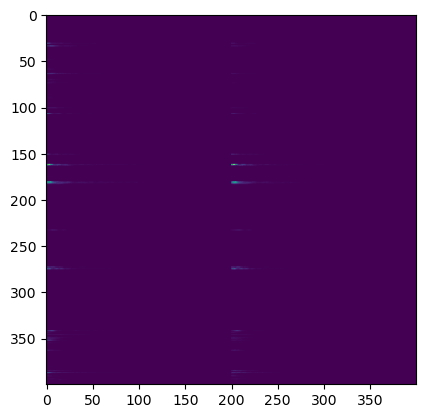

In [66]:
plt.imshow(specs[8,:,:])
eeg.shape

In [67]:
train

eeg_id     spec_id     min     max  patient_id  seizure_vote  \
0          568657   789577333     0.0    16.0       20654           0.0   
1          582999  1552638400     0.0    38.0       20230           0.0   
2          642382    14960202  1008.0  1032.0        5955           0.0   
3          751790   618728447   908.0   908.0       38549           0.0   
4          778705    52296320     0.0     0.0       40955           0.0   
...           ...         ...     ...     ...         ...           ...   
17084  4293354003  1188113564     0.0     0.0       16610           0.0   
17085  4293843368  1549502620     0.0     0.0       15065           0.0   
17086  4294455489  2105480289     0.0     0.0          56           0.0   
17087  4294858825   657299228     0.0    12.0        4312           0.0   
17088  4294958358   260520016  2508.0  2508.0       25986           0.0   

       lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote target  
0      0.000000      0.25   0.000000   0.166667    0.583333  Other  
1      0.857143      0.00   0.071429   0.000000    0.071429    LPD  
2      0.000000      0.00   0.000000   0.000000    1.000000  Other  
3      0.000000      1.00   0.000000   0.000000    0.000000    GPD  
4      0.000000      0.00   0.000000   0.000000    1.000000  Other  
...         ...       ...        ...        ...         ...    ...  
17084  0.000000      0.00   0.000000   0.500000    0.500000   GRDA  
17085  0.000000      0.00   0.000000   0.500000    0.500000   GRDA  
17086  0.000000      0.00   0.000000   0.000000    1.000000  Other  
17087  0.000000      0.00   0.000000   0.066667    0.933333  Other  
17088  0.000000      0.00   0.000000   0.000000    1.000000  Other  

[17089 rows x 12 columns]

In [69]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, train_feats, eegs, specs):
        self.train_feats = train_feats
        self.eegs = eegs
        self.specs = specs
    def __len__(self):
        return len(self.train_feats)
    def __getitem__(self, index):              
        x_eeg = self.eegs[index]
        x_spec = self.specs[index]
        y = self.train_feats[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].iloc[index].values      
        return x_eeg, x_spec, y

In [72]:
train_dataset = CustomDataset(train, eegs,specs)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=0, drop_last=False)
x1,x2,y = next(iter(train_dataloader))

In [74]:
x2.shape

torch.Size([8, 400, 400])

In [1]:
from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)

In [3]:
eps = 1e-8
data = all_eegs2[path]#np.load(path)
data_max = data.max()
data_min = data.min()
data = (data - data_min) / (data_max - data_min + eps)
data = torch.tensor(data).permute(2,0,1)

11138

In [8]:
import matplotlib.pyplot as plt

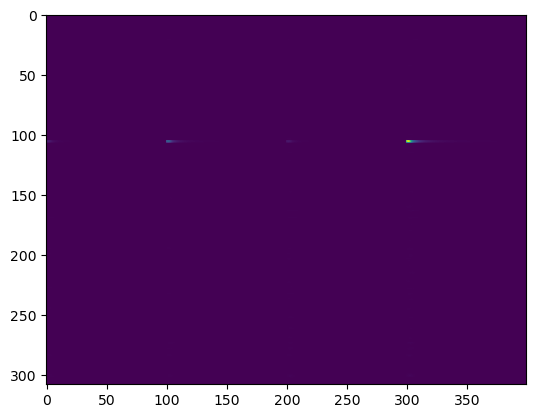

In [11]:
plt.imshow(spectrograms[789577333])

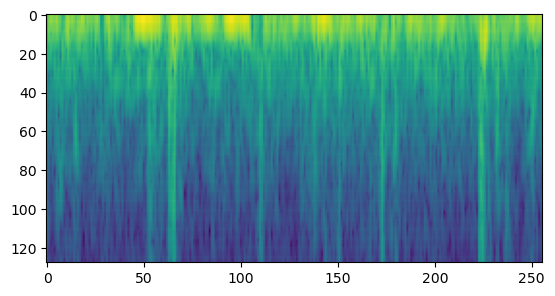

In [18]:
plt.imshow(all_eegs[568657][:,:,3])

In [10]:
train

eeg_id     spec_id     min     max  patient_id  seizure_vote  \
0          568657   789577333     0.0    16.0       20654           0.0   
1          582999  1552638400     0.0    38.0       20230           0.0   
2          642382    14960202  1008.0  1032.0        5955           0.0   
3          751790   618728447   908.0   908.0       38549           0.0   
4          778705    52296320     0.0     0.0       40955           0.0   
...           ...         ...     ...     ...         ...           ...   
17084  4293354003  1188113564     0.0     0.0       16610           0.0   
17085  4293843368  1549502620     0.0     0.0       15065           0.0   
17086  4294455489  2105480289     0.0     0.0          56           0.0   
17087  4294858825   657299228     0.0    12.0        4312           0.0   
17088  4294958358   260520016  2508.0  2508.0       25986           0.0   

       lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote target  
0      0.000000      0.25   0.000000   0.166667    0.583333  Other  
1      0.857143      0.00   0.071429   0.000000    0.071429    LPD  
2      0.000000      0.00   0.000000   0.000000    1.000000  Other  
3      0.000000      1.00   0.000000   0.000000    0.000000    GPD  
4      0.000000      0.00   0.000000   0.000000    1.000000  Other  
...         ...       ...        ...        ...         ...    ...  
17084  0.000000      0.00   0.000000   0.500000    0.500000   GRDA  
17085  0.000000      0.00   0.000000   0.500000    0.500000   GRDA  
17086  0.000000      0.00   0.000000   0.000000    1.000000  Other  
17087  0.000000      0.00   0.000000   0.066667    0.933333  Other  
17088  0.000000      0.00   0.000000   0.000000    1.000000  Other  

[17089 rows x 12 columns]

In [11]:
df = pd.read_csv(test_csv)
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()



Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

In [12]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

train

spec_id     min
eeg_id                        
568657       789577333     0.0
582999      1552638400     0.0
642382        14960202  1008.0
751790       618728447   908.0
778705        52296320     0.0
...                ...     ...
4293354003  1188113564     0.0
4293843368  1549502620     0.0
4294455489  2105480289     0.0
4294858825   657299228     0.0
4294958358   260520016  2508.0

[17089 rows x 2 columns]

In [13]:
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp
train

spec_id     min     max  patient_id
eeg_id                                            
568657       789577333     0.0    16.0       20654
582999      1552638400     0.0    38.0       20230
642382        14960202  1008.0  1032.0        5955
751790       618728447   908.0   908.0       38549
778705        52296320     0.0     0.0       40955
...                ...     ...     ...         ...
4293354003  1188113564     0.0     0.0       16610
4293843368  1549502620     0.0     0.0       15065
4294455489  2105480289     0.0     0.0          56
4294858825   657299228     0.0    12.0        4312
4294958358   260520016  2508.0  2508.0       25986

[17089 rows x 4 columns]

In [14]:
tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


eeg_id     spec_id     min     max  patient_id  seizure_vote  lpd_vote  \
0  568657   789577333     0.0    16.0       20654           0.0  0.000000   
1  582999  1552638400     0.0    38.0       20230           0.0  0.857143   
2  642382    14960202  1008.0  1032.0        5955           0.0  0.000000   
3  751790   618728447   908.0   908.0       38549           0.0  0.000000   
4  778705    52296320     0.0     0.0       40955           0.0  0.000000   

   gpd_vote  lrda_vote  grda_vote  other_vote target  
0      0.25   0.000000   0.166667    0.583333  Other  
1      0.00   0.071429   0.000000    0.071429    LPD  
2      0.00   0.000000   0.000000    1.000000  Other  
3      1.00   0.000000   0.000000    0.000000    GPD  
4      0.00   0.000000   0.000000    1.000000  Other

In [ ]:
    
# import albumentations as albu
# TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
# TARS2 = {x:y for y,x in TARS.items()}

# import torch
# from torch.utils.data import Dataset, DataLoader
# import albumentations as albu
# import numpy as np

# class CustomDataset(Dataset):
#     def __init__(self, data, mode='train', specs=spectrograms, eeg_specs=all_eegs, augment=False):
#         self.data = data
#         self.mode = mode
#         self.specs = specs
#         self.eeg_specs = eeg_specs
#         self.augment = augment

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         row = self.data.iloc[index]
#         if self.mode == 'test':
#             r = 0
#         else:
#             r = int((row['min'] + row['max']) // 4)
    
#         X_tensor = torch.zeros((128, 256, 8), dtype=torch.float32)
#         y_tensor = torch.zeros(6, dtype=torch.float32)
    
#         for k in range(4):
#             # EXTRACT 300 ROWS OF SPECTROGRAM
#             img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
    
#             # LOG TRANSFORM SPECTROGRAM
#             img = np.clip(img, np.exp(-4), np.exp(8))
#             img = np.log(img)
    
#             # STANDARDIZE PER IMAGE
#             ep = 1e-6
#             m = np.nanmean(img.flatten())
#             s = np.nanstd(img.flatten())
#             img = (img - m) / (s + ep)
#             img = np.nan_to_num(img, nan=0.0)
    
#             # CROP TO 256 TIME STEPS
#             X_tensor[14:-14, :, k] = torch.from_numpy(img[:, 22:-22] / 2.0)
    
#         # EEG SPECTROGRAMS
#         #print(X_tensor.shape)
#         img = self.eeg_specs[row.eeg_id]
#         X_tensor[:, :, 4:] = torch.tensor(img)
#         #print(list(row[TARGETS].values))
    
#         if self.mode != 'test':
#             y_tensor = torch.tensor(list(row[TARGETS].values))
    
#         if self.augment:
#             X_tensor = self.__random_transform(X_tensor)
    
#         return X_tensor, y_tensor

#     def __random_transform(self, img):
#         composition = albu.Compose([
#             albu.HorizontalFlip(p=0.5),
#             # albu.VerticalFlip(p=0.5),
#             # albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
#         ])
#         return composition(image=img)['image']

# def get_dataloader(data, batch_size=32, shuffle=False, augment=False, mode='train',
#                    specs=spectrograms, eeg_specs=all_eegs):
#     dataset = CustomDataset(data, mode, specs, eeg_specs, augment)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
#     return dataloader
    
    
# from sklearn.model_selection import train_test_split

# total_idx = np.arange(len(train))
# train_idx, val_idx = train_test_split(total_idx, test_size=0.2)
# train_idx

# def redo_classifier(model):
#     num_in_features = model.get_classifier().in_features
#     hidden_size = 64
#     n_classes=6
#     dropout_rate=.2
#     d2 = .1
#     for name, param in model.named_parameters():
#         ijk=0
#         #print (name)
        
#     # Replace the existing classifier. It's named: classifier
#     if "head.fc" in name:
#         model.head.fc = nn.Sequential(
#         nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
#         nn.SiLU(),
#         #nn.ReLU(inplace=True),
#         #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
#         #nn.GELU(),
#         # nn.BatchNorm1d(hidden_size),
#         nn.Dropout(d2),
#         nn.Linear(hidden_size, 32, bias=True),
#         #nn.Softmax(dim=0),
#         # nn.BatchNorm1d(32),
#         nn.Linear(32, out_features=n_classes, bias=True),
#         #nn.Softmax(dim=0)
#         )
#     elif "fc" in name:
#         model.fc = nn.Sequential(
#         nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
#         nn.Hardswish(),
#         #nn.ReLU(inplace=True),
#         #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
#         #nn.GELU(),
#         # nn.BatchNorm1d(hidden_size),
#         nn.Dropout(d2),
#         #nn.Linear(hidden_size, 32, bias=True),
#         #nn.SiLU(),
#         # nn.BatchNorm1d(32),
#         nn.Linear(hidden_size, out_features=n_classes, bias=True),
#         )
#     elif "classifier" in name:
#         model.classifier = nn.Sequential(
#         nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        
#         #nn.ReLU(inplace=True),
#         #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
#         #nn.GELU(),
#         # nn.BatchNorm1d(hidden_size),
#         nn.Dropout(d2),
#         nn.SiLU(),
#         #nn.Linear(hidden_size, 32, bias=True),
#         #nn.Hardswish(),
#         # nn.BatchNorm1d(32),
#         nn.Linear(hidden_size, out_features=n_classes, bias=True),
#         )
#     elif "head" in name:
#         model.head = nn.Sequential(
#         #nn.Dropout(dropout_rate, inplace=True),
#         nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
#         nn.Hardswish(),
#         #nn.ReLU(inplace=True),
#         #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
#         #nn.GELU(),
#         # nn.BatchNorm1d(hidden_size),
#         nn.Dropout(d2),
#         #nn.Linear(hidden_size, 32, bias=True),
#         #nn.Hardswish(),
#         # nn.BatchNorm1d(32),
#         nn.Linear(hidden_size, out_features=n_classes, bias=True),
#         )
#     #elif "neck" in name:
#     #    model.head = nn.Sequential(
#     #    nn.AdaptiveAvgPool2d((64,1)),
#     #    nn.Dropout(dropout_rate),
#     #    nn.Linear(in_features=1, out_features=64, bias=False),
#         #nn.LeakyReLU(.1,inplace=True),
#         #nn.Dropout(dropout_rate),
#         #nn.Linear(in_features=hidden_size, out_features=1, bias=False),
#         #nn.Sigmoid())
#     print (name)
#     #print (model)
#     return model

# # model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=6, in_chans=1)
# # model = redo_classifier(model)
# #model

# import torch
# import torch.nn as nn

# class CombinedModel(nn.Module):
#     def __init__(self, model1, model2, input_size1, input_size2):
#         super(CombinedModel, self).__init__()
#         self.model1 = model1
#         self.model2 = model2
#         self.fc = nn.Linear(32 * 2, 6)

#     def forward(self, x1, x2):
#         # Run the first tensor through the first model
#         output1 = self.model1(x1)

#         # Run the second tensor through the second model
#         output2 = self.model2(x2)

#         # Concatenate the outputs
#         combined_output = F.relu(torch.cat((output1, output2), dim=1))

#         # Pass the combined output through the final linear layer
#         final_output = self.fc(combined_output)

#         return final_output

# # Determine device availability
# import tqdm
# from sklearn.model_selection import train_test_split

# import albumentations as A
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f"Using device: {device}")

# # Assuming train_feats is defined and contains the training features and labels
# # total_idx = np.arange(len(train_feats))
# total_idx = np.arange(len(train))
# # np.random.shuffle(total_idx)

# gc.collect()
# # Cross-validation loop
# from sklearn.model_selection import KFold, GroupKFold
# #import tensorflow.keras.losses as tf_loss
# all_oof = []
# all_true = []
# criterion = nn.KLDivLoss(reduction='batchmean')
# #criterion = tf_loss.KLDivergence()
# gkf = GroupKFold(n_splits=3)
# train=train.iloc[0:2000]
# for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    
#     print('#'*25)
#     print(f'### Fold {i+1}')
#     print(len(valid_index))
    
#     train_gen = get_dataloader(train.iloc[train_index], batch_size=128, shuffle=True)
#     val_gen = get_dataloader(train.iloc[valid_index], batch_size=128, shuffle=False)
    
#     print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
#     print('#'*25)
#     model = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=8, drop_path_rate=.2,num_classes=1000,pretrained=True)

#     model = redo_classifier(model)

#     model.to(device)
#     optimizer = optim.NAdam(model.parameters(), lr=0.0004, weight_decay=0.02)
#     scheduler = CosineAnnealingLR(optimizer, T_max=12)

#     best_test_loss = float('inf')
#     train_losses = []
#     test_losses = []

#     for epoch in range(2):
#         model.train()
#         train_loss = []

#         count=0
#         for x,y in train_gen:
#             count=count+1
#             optimizer.zero_grad()

#             x = x.permute(0,3,1,2)

#             train_pred = model(x.to(device))
#             loss = KL_loss(y.to(device),train_pred)
#             #loss = criterion(F.log_softmax(train_pred, -1), y.to(device))
#             # loss = criterion(y,train_pred.detach().cpu().numpy())
#             # loss = torch.tensor(loss.numpy(), requires_grad=True)
#             loss.backward()
#             optimizer.step()
#             train_loss.append(loss.item())
#             if count%30==0:
#                 print(loss.item())

#         epoch_train_loss = np.mean(train_loss)
#         train_losses.append(epoch_train_loss)
#         print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

#         scheduler.step()

#         # Evaluation loop
#         model.eval()
#         test_loss = []
#         with torch.no_grad():
#             for x,y in val_gen:
#                 x = x.permute(0,3,1,2)
#                 #x = x.unsqueeze(1)
#                 #x = transforms(x)

#                 test_pred = model(x.to(device))
#                 loss = KL_loss(y.to(device),test_pred)
#                 #loss = criterion(F.log_softmax(train_pred, -1), y.to(device))
#                 # loss = criterion(test_pred.detach().cpu.numpy(),y)
#                 # loss = torch.tensor(loss.numpy())
#                 test_loss.append(loss.item())

#         epoch_test_loss = np.mean(test_loss)
#         test_losses.append(epoch_test_loss)
        
#         print(f"Epoch {epoch + 1}: Test Loss = {epoch_test_loss:.2f}")

#         # Save the model if it has the best test loss so far
#         if epoch_test_loss < best_test_loss:
#             best_test_loss = epoch_test_loss
#             torch.save(model.state_dict(), f"efficientnet_b0_fold{i}.pth")

#         gc.collect()

#     print(f"Fold {i + 1} Best Test Loss: {best_test_loss:.2f}")

#     model.eval()
#     test_preds = []
#     with torch.no_grad():
#         for x,y in val_gen:
#             x = x.permute(0,3,1,2)
#             test_pred = model(x.to(device))
#             test_preds.append(F.softmax(test_pred).detach().cpu())
    

#     all_oof.append(test_preds)
#     all_true.append(train.iloc[valid_index][TARGETS].values)
    
#     #del model, oof
#     gc.collect()
    
# all_oof = np.concatenate(all_oof)
# all_true = np.concatenate(all_true)

# # import sys
# # sys.path.append('/kaggle/input/kaggle-kl-div')
# from kaggle_kl_div import score

# oof = pd.DataFrame(test_preds.copy())
# oof['id'] = np.arange(len(oof))

In [18]:
all_oof = np.concatenate(test_preds)
oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

In [20]:
all_true = np.concatenate(all_true)
true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))



NameError: name 'score' is not defined

In [21]:
from kaggle_kl_div import score
cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

ParticipantVisibleError: All target values in submission must be at least zero

In [23]:
F.softmax(test_pred).detach().cpu()

tensor([[0.0520, 0.1847, 0.0103, 0.3419, 0.0925, 0.3186],
        [0.0488, 0.2304, 0.0332, 0.3607, 0.1923, 0.1347],
        [0.0573, 0.2278, 0.0336, 0.3858, 0.1689, 0.1265],
        [0.1244, 0.1121, 0.0652, 0.2452, 0.1760, 0.2772],
        [0.0563, 0.2184, 0.0283, 0.3341, 0.1489, 0.2141],
        [0.8423, 0.0529, 0.0157, 0.0410, 0.0181, 0.0301],
        [0.5804, 0.0950, 0.0866, 0.0922, 0.0771, 0.0687],
        [0.1007, 0.0950, 0.0488, 0.2715, 0.3149, 0.1691],
        [0.0749, 0.1354, 0.3654, 0.1107, 0.2276, 0.0860],
        [0.2793, 0.1033, 0.0887, 0.1784, 0.1637, 0.1865],
        [0.1990, 0.2180, 0.1317, 0.1738, 0.1522, 0.1252],
        [0.1198, 0.4694, 0.2035, 0.0769, 0.0574, 0.0731],
        [0.0265, 0.0273, 0.0197, 0.1591, 0.6232, 0.1442],
        [0.0337, 0.0740, 0.0150, 0.4237, 0.3169, 0.1367],
        [0.0961, 0.1225, 0.2758, 0.1365, 0.2428, 0.1262],
        [0.0424, 0.2279, 0.0153, 0.4013, 0.1403, 0.1729],
        [0.0419, 0.1085, 0.0188, 0.2317, 0.1893, 0.4098],
        [0.083